In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
import pickle

In [2]:
corpus_name = "OpenSubtitle"
save_dir = os.path.join("data", "save")
corpus = "./data/es.txt"

MAX_LENGTH = 20      # Tamaño de las frases
LINES_USED = 2_500_000 # Determina el tamaño de la parte de dataset que cogemos
MIN_COUNT  = 3       # Minimum word count threshold for trimming

In [3]:
# n_lines = 0
# with open(corpus, 'rb') as file:
#     for line in file:
#         n_lines += 1
# print(f'Numero de líneas: {n_lines}')

n_lines = 213_517_354
f"Lineas usadas sobre el total:{LINES_USED/n_lines:.3%}"

'Lineas usadas sobre el total:1.171%'

In [4]:
def printLines(stop=10, decode=False):
    with open(corpus, 'rb') as datafile:
        for i,line in enumerate(datafile):
            
            if decode:
                print(i,line.decode("utf-8"))
            else:
                print(i,line)
            if i==stop: break

printLines(10,True)

0 NETKonet trae para ti...

1 "Twenty"

2 [NEW Presenta]

3 [Una producción de A M Tree Pictures]

4 [Sidus HQ]

5 [Productor ejecutivo:

6 Kim Woo Taek]

7 Somos los típicos amigos de la secundaria que juraron que su amistad duraría para siempre.

8 Aunque las circunstancias del inicio de nuestra amistad no fueron especiales en cierto modo fueron especiales para nosotros.

9 Ejem... ejem.

10 Ejem...



In [45]:
#funcion para buscar ejemplos a la hora de tratar la puntuacion
def search_line(search_string,stop=10):
    n=0
    prev_line,line_found = "",""
    prnt = False
    
    with open(corpus, 'rb') as datafile:
        for i,line in enumerate(datafile):
            if prnt:
                print("-------------")
                print(prev_line.decode("utf-8"),line_found.decode("utf-8"),
                      line.decode("utf-8"), sep="\n")
                prnt = False
                n+=1
                if n==stop:
                    break
            if search_string in line: 
                line_found = line
                prnt = True
            else:
                prev_line = line
                
search_line(b".j ")

-------------
hacíamos competencia.

competencias de b-boys, competencias de d.j nos reuníamos o íbamos a su casa.

íbamos a garajes y el que abría la puerta veía 8 tipos sentados en tren de fumar un churrin.

-------------
Espera un momento.

Está...j roncando.

Snape ya estuvo aquí.

-------------
Eh, ¿qué tal os va con el baile de graduación?

¿Encontraste algún d.j barato de sótano?

Es gracioso.

-------------
¿alguna idea de quien querria hacer daño a la señora Carazo?

Mira, la chica era preciosa pero era f.o.j.j f.o.j.j?

- el jumbo fresco.

-------------
Lo se, de qué hablas?

Creo que es belludo...j Dijo belludo?

Si es medio lindo



In [41]:
#Procesado de la puntuación
def processLine(s):
    s = s.strip().lower().decode()
    s = re.sub(r"\.000",r" mil", s)
    s = re.sub(r"^-",       r"<GUION_INIC>", s)
    s = re.sub(r"-{2}",     r"<GUION_DOBL>", s)
    s = re.sub(r"\.{3}",    r"<TRIP_DOT>", s)
    s = re.sub(r"(\w)-(\w)",r"\1<GUION_INTER>\2", s)
    s = re.sub(r"([\).:!?])", r" \1", s) #separa puntuacion con espacio antes
    s = re.sub(r"([\(¡¿])", r"\1 ", s)   #separa puntuacion con espacio despues
    s = re.sub(r"([\"-,])", r" \1 ", s)  #espacio antes y despues
    s = re.sub(r"([.-])¿", r"\1 ¿", s)
    
    #separa los tokens
    s = re.sub(r"<", r" <", s)
    s = re.sub(r">", r"> ", s)
    
    s = re.sub(r"\s<GUION_INTER>\s",r"-", s)
    return s

print("#Test  0:", processLine("-t. -t".encode()))
print("#Test  1:", processLine("t. ¿t?".encode()))
print("#Test  2:", processLine("t... ¿¿¿t???".encode()))
print("#Test  3:", processLine("...t ...".encode()))
print("#Test  4:", processLine("???...!!!".encode()))
print("#Test  5:", processLine('"¿Cómo?"'.encode()))
print("#Test  6:", processLine('(--8:)'.encode()))
print("#Test  7:", processLine('electro-quimico'.encode()))
print("#Test  8:", processLine('que--'.encode()))
print("#Test  9:", processLine('-ivanov'.encode()))
print("#Test 10:", processLine('10.000, 5:45'.encode()))
print("#Test 11:", processLine('8:00 8:00h'.encode()))
print("#Test 12:", processLine('.¿ -¿'.encode()))

#Test  0:  <GUION_INIC> t . -t
#Test  1: t . ¿ t ?
#Test  2: t <TRIP_DOT>  ¿ ¿ ¿ t ? ? ?
#Test  3:  <TRIP_DOT> t  <TRIP_DOT> 
#Test  4:  ? ? ? <TRIP_DOT>  ! ! !
#Test  5:  " ¿ cómo ? " 
#Test  6:  (   <GUION_DOBL> 8 :  ) 
#Test  7: electro-quimico
#Test  8: que <GUION_DOBL> 
#Test  9:  <GUION_INIC> ivanov
#Test 10: 10 mil ,  5 :45
#Test 11: 8 :00 8 :00h
#Test 12:  . ¿  - ¿ 


In [7]:
def loadLines(file, total_lines=10, max_lenght=MAX_LENGTH):
    with open(file, 'rb') as datafile:
        n=0
        for i,line in enumerate(datafile):
            if max(line.find(b"["),line.find(b"]")) == -1: #filtra los comentarios
                s = processLine(line)
                if len(s.split(' ')) < max_lenght: #filtra frases largas
                    n+=1
                    yield i,s
            if n==total_lines: break
                
for i,l in loadLines(corpus,100): print(i,l)

0 netkonet trae para ti <TRIP_DOT> 
1  " twenty " 
7 somos los típicos amigos de la secundaria que juraron que su amistad duraría para siempre .
8 aunque las circunstancias del inicio de nuestra amistad no fueron especiales en cierto modo fueron especiales para nosotros .
9 ejem <TRIP_DOT>  ejem .
10 ejem <TRIP_DOT> 
12  <GUION_INIC>  ¿ le acariciaste el pecho a fo min ?
13  <GUION_INIC>  no .
14 no se lo acaricié ,  me quede allí parado tocándolo .
15  <GUION_INIC>  debes estar demente .
16  <GUION_INIC>  ¿ eso es una pregunta ?
17 ¿ crees que fue una pregunta ,  idiota ?
18 ey ,  que ya no somos niños .
19 ¿ en qué estaban pensando para pelear así por una chica ?
20 deben resolverlo de forma razonable .
21  <GUION_INIC>  háganlo con piedra ,  papel o tijeras .
22  <GUION_INIC>  es una buena idea . ¡ hagámoslo !
23 ok ,  solo haremos una ronda ,  como hombres .
24 ¡ piedra ,  papel o tijeras !
25 un hombre de verdad usa una piedra .
26 ¡ piedra ,  papel o tijeras !
27 hagámoslo de nue

In [8]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token
UNK_token = 3
class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print(f"keep_words {len(keep_words)} / { len(self.word2index)} = "
              f"{len(keep_words) / len(self.word2index):.4f}")

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

127440


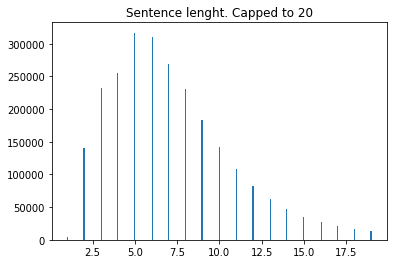

In [9]:
#TODO: multithread
voc = Voc(corpus_name)

hist = []  
for i,s in loadLines(corpus,LINES_USED):
    s_l = len(s.split(' '))
    hist.append(s_l)
    voc.addSentence(s)
    
print(f'Número de palabras: {voc.num_words}')

arr = np.array(hist)
plt.hist(arr, bins='auto')  # arguments are passed to np.histogram
plt.title(f"Sentence lenght. Capped to {MAX_LENGTH}")
plt.show()

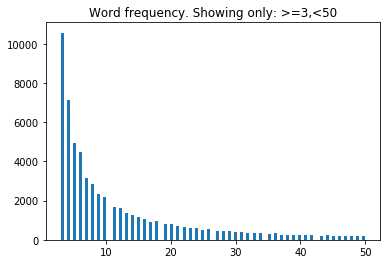

In [10]:
hist=[]
for i,n in enumerate(voc.word2count):
    c = voc.word2count[n]
    if c>=3:
        hist.append(c)
        
arr = np.array(hist)
plt.hist(arr, bins=100,range=(3,50))  # arguments are passed to np.histogram
plt.title(f"Word frequency. Showing only: >=3,<50")
plt.show()

In [11]:
from collections import Counter
c = Counter(voc.word2count)
c.most_common()

[('.', 1672097),
 ('', 1620714),
 (',', 632594),
 ('?', 467732),
 ('¿', 433355),
 ('<GUION_INIC>', 393838),
 ('no', 371366),
 ('que', 356257),
 ('de', 351773),
 ('a', 265535),
 ('!', 246838),
 ('la', 242848),
 ('¡', 209954),
 ('el', 207639),
 ('es', 197341),
 ('y', 169244),
 ('en', 165472),
 ('lo', 165338),
 ('un', 160483),
 ('qué', 136654),
 ('<TRIP_DOT>', 132866),
 ('me', 125658),
 ('por', 121235),
 ('una', 101751),
 ('te', 95640),
 ('se', 90376),
 ('los', 80830),
 ('con', 78195),
 ('está', 71518),
 ('para', 70693),
 ('si', 65628),
 ('mi', 64953),
 ('sí', 64943),
 ('"', 64894),
 ('pero', 63447),
 ('yo', 59477),
 ('eso', 56512),
 ('bien', 54844),
 ('las', 53792),
 ('su', 52448),
 ('le', 47975),
 ('aquí', 46844),
 ('al', 45608),
 ('más', 42368),
 ('del', 41274),
 ('tu', 41089),
 ('como', 40928),
 ('ya', 38407),
 ('todo', 35291),
 ('esto', 34376),
 ('ha', 32692),
 ('muy', 32056),
 ('vamos', 30872),
 ('hay', 30159),
 ('ahora', 30069),
 ('nada', 29230),
 ('esta', 28893),
 ('algo', 28604),

In [29]:
#Check de la puntuacion
punt_dict = {}
for word in c:
    for punt in ",.¿?¡!\":()-":
        if punt in word:
            if len(word)>1 and c[word]>3:
                punt_dict[word] = c[word]
c2 = Counter(punt_dict)
c2.most_common()

[(':00', 1131),
 ('.j', 975),
 (':30', 534),
 ('.uu', 265),
 ('.a', 250),
 ('.m', 229),
 ('.d', 228),
 ('-¿', 204),
 ('.5', 162),
 ('.s', 161),
 ('.i', 154),
 (':bi}¿', 144),
 ('.500', 142),
 ('.c', 134),
 (':15', 132),
 ('.o', 130),
 ('.e', 122),
 ('.¿', 110),
 (':bi}¡', 103),
 ('brogan-moore', 101),
 ('.y', 99),
 (':bi}', 99),
 (':10', 97),
 ('jean-luc', 95),
 ('sg-1', 91),
 ('.t', 88),
 ('rau-ru', 88),
 (':45', 87),
 ('mm-hmm', 86),
 ('-¡', 85),
 ('.|', 79),
 ('.b', 76),
 (':25', 68),
 ('yo-yo', 67),
 ('g-14', 62),
 ('.r', 60),
 ('.l', 59),
 ('coca-cola', 59),
 ('e-mail', 59),
 (':bi}el', 57),
 ('wada-san', 56),
 ('ujiie-san', 56),
 ('.no', 53),
 ('uh-huh', 51),
 (':22', 51),
 (':bi}pero', 51),
 ('pah-wraiths', 50),
 (':55', 49),
 (':26', 47),
 (':bi}la', 47),
 (':bi}y', 46),
 ('.2', 44),
 ('jin-a', 44),
 (':bi}no', 44),
 ('.k', 43),
 ('bate-huevos', 42),
 ('.n', 42),
 ('.¡', 42),
 ('.30', 42),
 (':50', 42),
 (':bi}-', 42),
 ('.7', 41),
 ('.de', 41),
 ('.que', 41),
 ('hana-ogi', 41)

In [13]:
voc.trim(MIN_COUNT)

keep_words 72510 / 127437 = 0.5690


In [14]:
# Filter out sentences with trimmed words
def contain_trimmed(sentence):
    for word in sentence.split(' '):
        if word not in voc.word2index:
            return True

In [15]:
total = 0
deleted = 0
for i,s in loadLines(corpus,LINES_USED):
    total += 1
    if contain_trimmed(s): deleted +=1
        
print(f"Trimmed from {total} pairs to {total-deleted}, {(total-deleted) / total:.4f} of total")

Trimmed from 2500000 pairs to 2433152, 0.9733 of total


In [16]:
#1 cargar todas diccionario con line index y sentence
#2 elminiar las mas largas de 50
#3 añadir las palabras al vocabulario
#4 eliminar las sentence con palabras que no salen
#5 pasar los pares con line index contiguos

In [17]:
def indexesFromSentence(sentence, voc):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]

def gen_pairs(how_many, voc):
    first_inpt = True
    n=0
    for out_idx,out_snt in loadLines(corpus,LINES_USED):
        if first_inpt:
            inp_idx, inp_snt = out_idx,out_snt
            first_inpt = False
            continue

        if inp_idx+1 == out_idx: #frases contiguas
            if not contain_trimmed(inp_snt) and not contain_trimmed(out_snt):#every word is in Voc
                n+=1
                yield [indexesFromSentence(inp_snt, voc),indexesFromSentence(out_snt, voc)]
        if n==how_many:break
        inp_idx, inp_snt = out_idx,out_snt
        
# for pair in gen_pairs():
#     print(pair)

In [18]:
pairs = list(gen_pairs(LINES_USED,voc))

In [19]:
"""
se obtienen menos pares que lineas usadas, con lineas usadas se crea el diccionario, con ese diccionario elegimos 
las palabras con las que quedarnos, se descartan las lineas con palabras borradas y de ahi solo cogemos los pares
de lineas contiguos
"""
len(pairs)

2322155

In [20]:
#Guardar pairs y voc
with open('data/pairs.pkl', 'wb') as file:
    pickle.dump(pairs, file)

with open('data/voc.pkl', 'wb') as file:
    voc.__module__ = "Voc"
    pickle.dump(voc, file)

In [21]:
# # Example for validation
# small_batch_size = 6
# pairs_list = [random.choice(pairs) for _ in range(small_batch_size)]
# batches = batch2TrainData(pairs_list)
# input_variable, lengths, target_variable, mask, max_target_len = batches

# print("input_variable:\n", input_variable)
# print("lengths:", lengths)
# print("target_variable:\n", target_variable)
# print("mask:\n", mask)
# print("max_target_len:", max_target_len)